# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

transformers.__version__

'4.30.1'

# Dataset

In [2]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    
    './.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-0392de',
    './.ds/HuggingFaceH4starchat_beta-None-N_6000-ns_3-mc_True-dc99f8',
    './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_True-a50b5f'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds1 = concatenate_datasets([load_from_disk(f) for f in fs])
ds1

Dataset({
    features: ['hs1', 'ans1', 'hs2', 'ans2', 'true', 'index', 'version', 'info', 'input_truncated', 'prob_y', 'prob_n', 'text_ans', 'input_text'],
    num_rows: 36000
})

In [3]:
def rows_item(row):
    """
    transform a row by turning singe dim arrays into items
    """
    for k,x in row.items():
        if isinstance(x, np.ndarray) and x.ndim==0:
            row[k]=x.item()
    return row

def ds_info2df(ds):
    info = list(ds['info'])
    d = pd.DataFrame([rows_item(r) for r in info])
    return d

def ds2df(ds):
    df = ds_info2df(ds)
    df_ans = ds.select_columns(['ans1', 'ans2', 'true', 'index', 'prob_y', 'prob_n', 'version']).with_format("numpy").to_pandas()
    df = pd.concat([df, df_ans], axis=1)
    
    # derived
    df['dir_true'] = df['ans2'] - df['ans1']
    df['conf'] = (df['ans1']-df['ans2']).abs()  
    df['llm_prob'] = (df['ans1']+df['ans2'])/2
    df['llm_ans'] = df['llm_prob']>0.5
    return df

## Filter

In [4]:
# lets select only the ones where
df = ds2df(ds1)
df

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,index,prob_y,prob_n,version,dir_true,conf,llm_prob,llm_ans
0,True,Title: Horrible and dangerous for kids!\n\nCon...,True,0,lie,0.058716,0.153931,0,0,0.057861,0.926270,lie,0.095215,0.095215,0.106323,False
1,True,Title: Order with caution\n\nContent: I ordere...,True,0,lie,0.373535,0.476074,0,1,0.371094,0.621582,lie,0.102539,0.102539,0.424805,False
2,True,Title: A big disappointment\n\nContent: This m...,True,0,lie,0.063660,0.204224,0,2,0.063416,0.932129,lie,0.140564,0.140564,0.133942,False
3,True,Title: Came F*$%ed Up!!\n\nContent: ok so i go...,True,0,lie,0.259521,0.054138,0,3,0.252686,0.720215,lie,-0.205383,0.205383,0.156830,False
4,True,Title: broken\n\nContent: I was anticipating t...,True,0,lie,0.151001,0.265625,0,4,0.148071,0.832031,lie,0.114624,0.114624,0.208313,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,True,Review Title: Great for burning CDS\n\nReview ...,False,1,truth,0.522949,0.745117,1,7995,0.518555,0.472168,truth,0.222168,0.222168,0.634033,True
35996,False,Review Title: Horrible...\n\nReview Content: I...,False,0,truth,0.001739,0.001056,0,7996,0.001735,0.994629,truth,-0.000683,0.000683,0.001397,False
35997,False,Review Title: one of the worst books to use fo...,False,0,truth,0.016632,0.000480,0,7997,0.016357,0.965820,truth,-0.016152,0.016152,0.008556,False
35998,False,"Review Title: Not for C, C++ programmers\n\nRe...",False,0,truth,0.005379,0.008308,0,7998,0.005375,0.992676,truth,0.002930,0.002930,0.006844,False


In [5]:


# just select the question where the model knows the answer. 
d = df.query('version=="truth"').set_index("index")
# these are the ones where it got it right when asked to tell the truth
known_indices = d[d.llm_ans==d.true_answer].index

# convert to row numbers, and use datasets to select
known_rows = df['index'].isin(known_indices)
known_rows_i = df[known_rows].index

# also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
m = np.abs(df.ans1-df.ans2)>0.10
significant_rows = m[m].index

allowed_rows_i = set(known_rows_i).intersection(significant_rows)
ds = ds1.select(allowed_rows_i)
ds

Dataset({
    features: ['hs1', 'ans1', 'hs2', 'ans2', 'true', 'index', 'version', 'info', 'input_truncated', 'prob_y', 'prob_n', 'text_ans', 'input_text'],
    num_rows: 14082
})

## Transform: Normalize by activation

In [6]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs1 = small_ds['hs1'].reshape((b, -1))

# scaler = RobustScaler()
# hs2 = scaler.fit_transform(hs1)

# def normalize_hs(hs1, hs2):
#     b = len(hs1)
#     hs1 = scaler.transform(hs1.reshape((b, -1)))
#     hs2 = scaler.transform(hs2.reshape((b, -1)))
#     return {'hs1':hs1, 'hs2': hs2}

# # # Plot
# # plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# # plt.hist(hs2.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# # plt.legend()
# # plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs1', 'hs2'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs1', 'hs2'])
# ds

## Lightning DataModule

In [7]:
df = ds2df(ds)
df.head(4)

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,index,prob_y,prob_n,version,dir_true,conf,llm_prob,llm_ans
0,True,Title: Order with caution\n\nContent: I ordere...,True,0,lie,0.373535,0.476074,0,1,0.371094,0.621582,lie,0.102539,0.102539,0.424805,False
1,True,Title: A big disappointment\n\nContent: This m...,True,0,lie,0.063660,0.204224,0,2,0.063416,0.932129,lie,0.140564,0.140564,0.133942,False
2,True,Title: Came F*$%ed Up!!\n\nContent: ok so i go...,True,0,lie,0.259521,0.054138,0,3,0.252686,0.720215,lie,-0.205383,0.205383,0.156830,False
3,True,Title: broken\n\nContent: I was anticipating t...,True,0,lie,0.151001,0.265625,0,4,0.148071,0.832031,lie,0.114624,0.114624,0.208313,False


What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [8]:
def bool2switch(x):
    """[0,1]->[-1,1]"""
    return x*2-1

def switch2bool(x):
    """[-1,1]->[0,1]"""
    return (x+1)/2

assert switch2bool(-1)==0
assert switch2bool(1)==1
assert bool2switch(1)==1
assert bool2switch(0)==-1


def make_y(df):
    # label: is ans2 more true than ans1
    # so we ask does ans2 have greater probabiliy on "positive" than ans1
    # then, when the right answer is negative we swap the sign
    true_switch_sign = df.true_answer*2-1
    distance = (df.ans2-df.ans1) * true_switch_sign
    # y = bool2switch(distance>0)
    return distance

In [9]:


class imdbHSDataModule(pl.LightningDataModule):

    def __init__(self,
                 ds,
                 batch_size=32,
                ):
        super().__init__()
        self.save_hyperparameters(ignore=["ds"])
        self.ds = ds.shuffle(seed=42)

    def setup(self, stage: str):
        h = self.hparams
        
        # extract data set into N-Dim tensors and 1-d dataframe
        self.ds_hs = (
            self.ds.select_columns(['hs1', 'hs2'])
            .with_format("numpy")
        )
        self.df = ds2df(self.ds)
        
        y_cls = make_y(self.df)
        
        self.y = y_cls.values
        self.df['y'] = y_cls
        
        b = len(self.ds_hs)
        self.hs1 = self.ds_hs['hs1'].transpose(0, 2, 1)
        self.hs2 = self.ds_hs['hs2'].transpose(0, 2, 1)
        self.ans1 = self.df['ans1'].values
        self.ans2 = self.df['ans2'].values

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(self.y)
        
        self.val_split = vs = int(n * 0.5)
        self.test_split = ts = int(n * 0.75)
        hs1_train, hs2_train, y_train = self.hs1[:vs], self.hs2[:vs], self.y[:vs]
        hs1_val, hs2_val, y_val = self.hs1[vs:ts], self.hs2[vs:ts], self.y[vs:ts]
        hs1_test, hs2_test, y_test = self.hs1[ts:],self. hs2[ts:], self.y[ts:]
        
        
        to_ds = lambda x0, x1, y: TensorDataset(torch.from_numpy(x0).float(),
                                      torch.from_numpy(x1).float(),
                                      torch.from_numpy(y).float()
                                      )

        self.ds_train = to_ds(hs1_train, hs2_train, y_train)

        self.ds_val = to_ds(hs1_val, hs2_val, y_val)

        self.ds_test = to_ds(hs1_test, hs2_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.ds_train,
                          batch_size=self.hparams.batch_size,
                          drop_last=True,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.hparams.batch_size, drop_last=True,)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.hparams.batch_size, drop_last=True,)


In [10]:
batch_size = 128
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()


Loading cached shuffled indices for dataset at /home/ubuntu/Documents/mjc/elk/discovering_latent_knowledge/notebooks/.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-0392de/cache-35c10a94e92fef40.arrow


In [11]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

torch.Size([128, 6144, 19])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [12]:
# dm.y

In [13]:
# n = len(df)

# # Define X and y
# X = dm.hs1-dm.hs2
# y = dm.y>0

# # split
# n = len(y)
# max_rows = 1000
# print('split size', n//2)
# X_train, X_test = X[:n//2], X[n//2:]
# y_train, y_test = y[:n//2], y[n//2:]
# X_train = X_train[:max_rows]
# y_train = y_train[:max_rows]
# X_test = X_test[:max_rows]
# y_test = y_test[:max_rows]

# # scale
# scaler = RobustScaler()
# scaler.fit(X_train)
# X_train2 = scaler.transform(X_train)
# X_test2 = scaler.transform(X_test)
# print('lr')

# lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=380)
# lr.fit(X_train2, y_train>0)

In [14]:
# print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
# print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

# m = df['lie'][n//2:][:max_rows]
# y_test_pred = lr.predict(X_test2)
# acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
# acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
# print(f'test acc w lie {acc_w_lie:2.2%}')
# print(f'test acc wo lie {acc_wo_lie:2.2%}')

In [15]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [82]:
class MLPProbe(nn.Module):
    def __init__(self, c_in, depth=0, hs=16, dropout=0):
        super().__init__()

        layers = [
            nn.BatchNorm1d(c_in, affine=False),  # this will normalise the inputs
            nn.Dropout1d(dropout),
            
            nn.Conv1d(c_in, hs*(depth+1), kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(hs*(depth+1)),
        ]
        for i in range(depth):
            layers += [
                nn.Conv1d(hs*(depth-i+1), hs*(depth-i), 2),
                nn.ReLU(),
                nn.BatchNorm1d(hs*(depth-i)),
                
            ]
        layers += [nn.AdaptiveAvgPool1d(1)]
        self.net = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Linear(hs, hs), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hs, 1)            
        )

    def forward(self, x):
        h = self.net(x)
        # print(1, h.shape)
        h = h.squeeze(-1)
        # print(1, h.shape)
        return self.head(h)


In [83]:
from pytorch_optimizer import Ranger21
import torchmetrics

from torchmetrics import Metric, MetricCollection, Accuracy, AUROC
    
class CSS(pl.LightningModule):
    def __init__(self, c_in, total_steps, depth=1, hs=16, lr=4e-3, weight_decay=1e-9, dropout=0):
        super().__init__()
        self.probe = MLPProbe(c_in, depth=depth, dropout=dropout, hs=hs)
        self.save_hyperparameters()
        
        self.loss_fn = nn.SmoothL1Loss()
        
        # metrics for each stage
        metrics_template = MetricCollection({
            'acc': Accuracy(task="binary"), 
            'auroc': AUROC(task="binary")
        })
        self.metrics = torch.nn.ModuleDict({
            f'metrics_{stage}': metrics_template.clone(prefix=stage+'/') for stage in ['train', 'val', 'test']
        })
        
    def forward(self, x):
        return self.probe(x).squeeze(1)
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
        
        loss = self.loss_fn(ypred1-ypred0, y)
        self.log(f"{stage}/loss", loss)
        
        m = self.metrics[f'metrics_{stage}']
        
        y_cls = switch2bool(ypred1-ypred0)
        m(y_cls, y>0.)
        self.log_dict(m, on_epoch=True, on_step=False)
        return loss
    
    def training_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx=0):
        return self._step(batch, batch_idx, stage='val')
    
    def predict_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='pred').cpu().detach()
    
    def test_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='test')
    
    def configure_optimizers(self):
        """use ranger21 from  https://github.com/kozistr/pytorch_optimizer"""
        optimizer = Ranger21(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,       
            num_iterations=self.hparams.total_steps,
        )
        return optimizer
    
    

# Run

In [84]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [85]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# b

In [86]:
# init the model
max_epochs = 42
c_in = b[0].shape[1]
print(b[0].shape)
net = CSS(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=6, hs=42*2, lr=3e-3, 
        #   weight_decay=1e-4, 
        #   dropout=0.1,
          )
net

torch.Size([128, 6144, 19])


CSS(
  (probe): MLPProbe(
    (net): Sequential(
      (0): BatchNorm1d(6144, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): Dropout1d(p=0, inplace=False)
      (2): Conv1d(6144, 588, kernel_size=(2,), stride=(1,))
      (3): ReLU()
      (4): BatchNorm1d(588, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(588, 504, kernel_size=(2,), stride=(1,))
      (6): ReLU()
      (7): BatchNorm1d(504, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv1d(504, 420, kernel_size=(2,), stride=(1,))
      (9): ReLU()
      (10): BatchNorm1d(420, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Conv1d(420, 336, kernel_size=(2,), stride=(1,))
      (12): ReLU()
      (13): BatchNorm1d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Conv1d(336, 252, kernel_size=(2,), stride=(1,))
      (15): ReLU()
      (16): BatchNorm1d(252, eps=1e-05, momentum=0.1, af

In [87]:
# DEBUG
with torch.no_grad():
    b = next(iter(dl_train))
    b2 = [bb.to(net.device) for bb in b]
    y = net(b2[0])
y.shape, b[2].shape

(torch.Size([128]), torch.Size([128]))

In [88]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [89]:
trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | probe   | MLPProbe     | 8.8 M 
1 | loss_fn | SmoothL1Loss | 0     
2 | metrics | ModuleDict   | 0     
-----------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.281    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=42` reached.


# Read hist

In [90]:
# import pytorch_lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
from pathlib import Path
import pandas as pd

def read_metrics_csv(metrics_file_path):
    df_hist = pd.read_csv(metrics_file_path)
    df_hist["epoch"] = df_hist["epoch"].ffill()
    df_histe = df_hist.set_index("epoch").groupby("epoch").mean()
    return df_histe
        
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,train/loss,step,val/loss,val/acc,val/auroc,train/acc,train/auroc
epoch,,,,,,,
0,0.026391,32.846154,0.018544,0.757812,0.841727,0.616761,0.673646
1,0.017188,87.846154,0.013567,0.853299,0.928400,0.802131,0.885745
2,0.014117,142.846154,0.015562,0.866319,0.902572,0.841051,0.909347
3,0.012864,197.846154,0.011800,0.884259,0.947917,0.861932,0.922992
4,0.010313,252.846154,0.017494,0.810185,0.858027,0.884233,0.933424
5,0.009783,307.846154,0.012117,0.892072,0.947159,0.891761,0.940150
6,0.008313,362.846154,0.013329,0.856771,0.920588,0.922443,0.972182
7,0.007790,417.846154,0.011072,0.903935,0.958935,0.934943,0.977583
8,0.005486,472.846154,0.010870,0.893229,0.948973,0.944176,0.985607


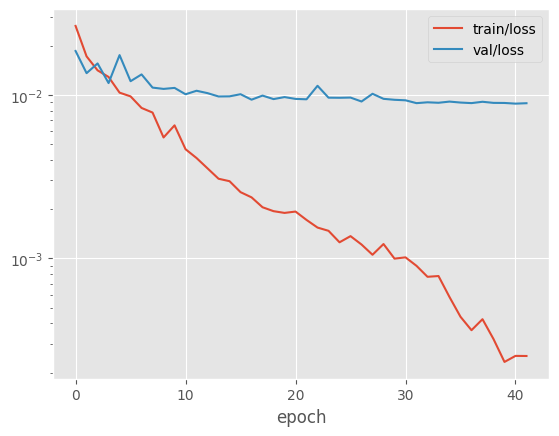

In [91]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

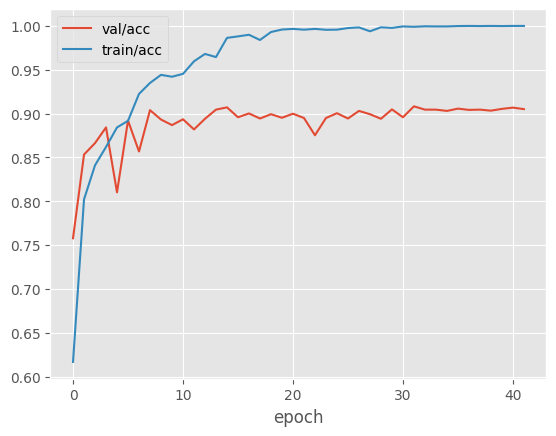

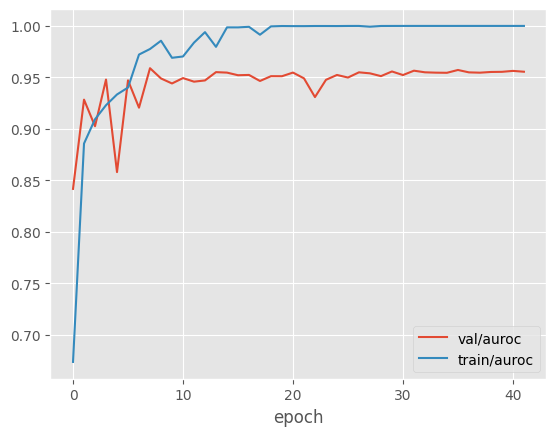

In [92]:
for key in ['acc', 'auroc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [93]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │          0.96875          │    0.9543434381484985     │
│        test/auroc         │            1.0            │    0.9901264905929565     │    0.9843764305114746     │
│         test/loss         │   4.88237856188789e-05    │   0.008885718882083893    │   0.008571253158152103    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/loss/dataloader_idx_0': 4.88237856188789e-05,
  'test/acc/dataloader_idx_0': 1.0,
  'test/auroc/dataloader_idx_0': 1.0},
 {'test/loss/dataloader_idx_1': 0.008885718882083893,
  'test/acc/dataloader_idx_1': 0.96875,
  'test/auroc/dataloader_idx_1': 0.9901264905929565},
 {'test/loss/dataloader_idx_2': 0.008571253158152103,
  'test/acc/dataloader_idx_2': 0.9543434381484985,
  'test/auroc/dataloader_idx_2': 0.9843764305114746}]

In [94]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(3521,)

In [95]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.test_split:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans1']+df_test['ans2'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans1']-df_test['ans2']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,index,prob_y,prob_n,version,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob
10561,False,Review Title: I really like the system.\n\nRev...,True,1,lie,0.812012,0.665039,1,2990,0.798340,0.183838,lie,-0.146973,0.146973,0.738525,True,False,False,0.379883
10562,True,"Title: Unwatchable\n\nContent: Bad, and not ev...",True,0,lie,0.219727,0.043640,0,5346,0.218140,0.773438,lie,-0.176086,0.176086,0.131683,False,True,True,0.653320
10563,False,Title: This tire is more than I expected.\n\nC...,True,1,lie,0.910156,0.754395,1,1967,0.906738,0.088379,lie,-0.155762,0.155762,0.832275,True,False,False,0.486328
10564,False,Title: Three in a row\n\nContent: Congratulati...,True,1,lie,0.588379,0.787109,1,2345,0.582031,0.406250,lie,0.198730,0.198730,0.687744,True,True,True,0.614746
10565,True,Review Title: Hardcore Christian Metal\n\nRevi...,False,1,truth,0.877441,0.765137,1,164,0.872070,0.120850,truth,-0.112305,0.112305,0.821289,True,False,False,0.477539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14077,False,Title: Halliwell shares an insightful perspect...,True,1,lie,0.584473,0.366211,1,1445,0.581543,0.412354,lie,-0.218262,0.218262,0.475342,False,False,False,0.364258
14078,True,Title: Riveting\n\nContent: The action in this...,False,1,truth,0.688477,0.577148,1,589,0.685547,0.309082,truth,-0.111328,0.111328,0.632812,True,False,False,0.456543
14079,True,Title: Great ball\n\nContent: Great run-around...,False,1,truth,0.322021,0.817871,1,1681,0.315186,0.662109,truth,0.495850,0.495850,0.569946,True,True,True,0.789062
14080,False,Title: A triumph for music\n\nContent: Barry M...,True,1,lie,0.491699,0.779297,1,1757,0.482178,0.497314,lie,0.287598,0.287598,0.635498,True,True,True,0.636719


In [96]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'lie==True') # it was ph told to lie
get_acc_subset(df_test, 'lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==true_answer') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==desired_answer') # the llm gave the desired ans
get_acc_subset(df_test, 'lie==True & llm_ans==desired_answer') # it was told to lie, and it did lie
get_acc_subset(df_test, 'lie==True & llm_ans!=desired_answer')

probe results on subsets of the data
acc=90.37% [lie==True]
acc=92.14% [lie==False]
acc=93.69% [llm_ans==true_answer]
acc=90.66% [llm_ans==desired_answer]
acc=75.76% [lie==True & llm_ans==desired_answer]
acc=93.00% [lie==True & llm_ans!=desired_answer]


0.9300164024056862

# RESULTS

In [97]:
roc_auc = roc_auc_score(df_test['y'], y_test_pred_bool)

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ roc_auc={roc_auc:2.2%} from probe")

⭐PRIMARY METRIC⭐ roc_auc=96.05% from probe
